### Supermarket data science case study - Exploring first data


### >> Importing packages

In [3]:
import pandas as pd
import numpy as np

import sys
import altair as alt

import vegafusion as vf

import sklearn

from datetime import datetime
from sklearn.pipeline import Pipeline, make_pipeline

alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

### >> Functions

In [4]:
def f_concat(l_input):

    # Initialize.
    dummy = ""
    n_len = len(l_input)

    if n_len == 1:
        return l_input[0]

    # Loop through text elements.
    for i in range(n_len - 1):
        dummy = dummy + l_input[i] + ", "

    # Append last element.
    dummy = dummy + "and " + l_input[n_len - 1]

    # Return result.
    return dummy

In [3]:
def basic_description(df):
    print(
        f"-> Contains:                {round(df.shape[0]/1e6, 4)} million observations and has {df.shape[1]} Feature names: {f_concat(df.columns)}.\n"
    )
    print(
        f"-> Has size of              {round(sys.getsizeof(df)/1024/1024/1024, 2)} GB."
    )

In [2]:
def extract_datetime_features(df):
    """
    Extracting datetime features
    year, month, day of month, weekday (1-7), week number-year, week_year_date
    """
    df = df.copy()

    # Ensure the date column is sorted
    df = df.sort_values("date")

    # df["year"] = df["date"].dt.year
    # df["month"] = df["date"].dt.month
    # df["day"] = df["date"].dt.day

    # Adjusting weekday to start from 1 (Monday) to 7 (Sunday)
    df["weekday"] = df["date"].dt.dayofweek + 1

    # Adding week number feature
    df["week_number"] = df["date"].dt.isocalendar().week

    # Adding week number-year feature
    df["week_year"] = df["week_number"].astype(str).str.zfill(2) + df["year"].astype(
        str
    )

    # Convert week_year to datetime with monday as startdate of week
    df["week_year_date"] = pd.to_datetime(
        df["year"].astype(str) + df["week_number"].astype(str).str.zfill(2) + "1",
        format="%Y%W%w",
    )

    # Adding trend feature: number of weeks since the start of the dataset
    start_date = df["date"].min()

    df["weeks_since_start"] = ((df["date"] - start_date).dt.days / 7).astype(int) + 1

    return df

In [3]:
def extract_datetime_features(df):
    """
    Extracting datetime features:
    year, month, day of month, weekday (1-7), week number-year, and trend (weeks since start, starting at 1)
    """
    # Ensure the date column is sorted
    df = df.copy().sort_values("date")

    # Use isocalendar for consistent week-based calculations

    iso_calendar = df["date"].dt.isocalendar()

    # Year, Month, Day
    # df["year"] = iso_calendar.year
    # df["month"] = df["date"].dt.month
    # df["day"] = df["date"].dt.day

    # Weekday (1 = Monday, 7 = Sunday)
    df["weekday"] = iso_calendar.day

    # Week number
    df["week_number"] = iso_calendar.week

    # Week-year
    df["week_year"] = df["week_number"].astype(str).str.zfill(2) + df["year"].astype(
        str
    )

    # Convert week_year to datetime with monday as startdate of week
    df["week_year_date"] = pd.to_datetime(
        df["year"].astype(str) + df["week_number"].astype(str).str.zfill(2) + "1",
        format="%Y%W%w",
    )

    # First day of the ISO year containing the start date

    start_date = df["date"].min()
    start_year_first_day = datetime(start_date.year, 1, 1)

    # 'search' for first monday of year
    while start_year_first_day.isocalendar()[1] != 1:

        start_year_first_day = start_year_first_day + pd.Timedelta(days=1)

    ##Itemweek number
    # Weeks since start (aligned with ISO week numbers)
    df["weeks_since_start"] = (
        iso_calendar.week + (iso_calendar.year - start_year_first_day.year) * 52
    )

    # Adjust weeks_since_start to start from 1
    df["weeks_since_start"] = (
        df["weeks_since_start"] - df["weeks_since_start"].min() + 1
    )

    return df

In [ ]:
# df_0 = extract_datetime_features(df_0)

# df_0.info()

In [ ]:
# df_0.sample(10)

### Imputing sales data

In [11]:
df_sales = f_get_data(0)

# df_0 = df_0[df_0["year"].isin([2014, 2015])].drop(columns=['id', 'day','month' ])
df_sales = df_sales.drop(columns=["id", "day", "month"])
print("-" * 50)
df_sales.info()

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    uint8         
 1   item_nbr     uint32        
 2   unit_sales   float32       
 3   onpromotion  boolean       
 4   year         int32         
 5   date         datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(1), uint32(1), uint8(1)
memory usage: 2.7 GB


In [12]:
# To check how big df wil get after NaN inputing per year
df_sales_2013 = df_sales[(df_sales["year"] == 2013)]
df_sales_2014 = df_sales[(df_sales["year"] == 2014)]
df_sales_2015 = df_sales[(df_sales["year"] == 2015)]
df_sales_2016 = df_sales[(df_sales["year"] == 2016)]
df_sales_2017 = df_sales[(df_sales["year"] == 2017)]

In [54]:
basic_description(df_sales_2017)  # --> 23.8 million observations and 0.69 GB

-> Contains:                23.8 million observations and has 6 Feature names: store_nbr, item_nbr, unit_sales, onpromotion, year, and date.

-> Has size of              0.69 GB.


In [31]:
basic_description(df_sales)  # orginal = 2.7GB and after NaN inputing ~7GB

The data of {df} 

-> Contains:                125.5 million observations and has 6 Feature names: store_nbr, item_nbr, unit_sales, onpromotion, year, and date.

-> Has size of              2.69 GB.


In [ ]:
df_0_36_648313 = df_0[
    (df_0["store_nbr"] == 53)
    & (
        df_0["item_nbr"].isin(
            [
                627887,
                759890,
            ]
        )
    )
].drop(
    columns=[
        "weekday",
        "week_number",
        "week_year",
        "weeks_since_start",
        "weeks_since_start_2",
    ]
)
# 53 759890 --> starts 2014-05-29, next date 2024-05-31

In [16]:
df_0_36_759890 = df_0[(df_0["store_nbr"] == 53) & (df_0["item_nbr"] == 759890)]

In [45]:
df_0_36_3items_3stores = df_0[
    (df_0["store_nbr"].isin([53, 6]))
    & (df_0["item_nbr"].isin([627887, 759890, 1160872]))
].drop(columns=["id"])

In [49]:
df_0_36_3items_3stores.tail(40).sort_values(by=["date", "store_nbr", "item_nbr"])

,store_nbr,item_nbr,unit_sales,onpromotion,day,year,month,date
65526694,6,627887,1.0,False,20,2015,9,2015-09-20
65526804,6,759890,2.0,False,20,2015,9,2015-09-20
65527371,6,1160872,12.0,False,20,2015,9,2015-09-20
65604559,53,627887,1.0,False,20,2015,9,2015-09-20
65604651,53,759890,2.0,False,20,2015,9,2015-09-20
65605110,53,1160872,3.0,False,20,2015,9,2015-09-20
65617336,6,759890,1.0,False,21,2015,9,2015-09-21
65617859,6,1160872,12.0,False,21,2015,9,2015-09-21
65690752,53,1160872,1.0,False,21,2015,9,2015-09-21
65702624,6,759890,4.0,False,22,2015,9,2015-09-22


In [ ]:
df_0_36_3items_3stores = filling_dates_NaN(df_0_36_3items_3stores)

In [43]:
df_final_check = df_0_36_3items_3stores[
    (df_0_36_3items_3stores["date"] > "2015-09-12")
].sort_values(by=["date", "store_nbr", "item_nbr"])

df_final_check.head(60)

,item_nbr,date,store_nbr,unit_sales,onpromotion,day,year,month
620,627887,2015-09-13,53.0,1.0,False,13.0,2015.0,9.0
1368,759890,2015-09-13,NaN,NaN,<NA>,NaN,NaN,NaN
2116,1160872,2015-09-13,53.0,9.0,False,13.0,2015.0,9.0
621,627887,2015-09-14,NaN,NaN,<NA>,NaN,NaN,NaN
1369,759890,2015-09-14,NaN,NaN,<NA>,NaN,NaN,NaN
2117,1160872,2015-09-14,53.0,7.0,False,14.0,2015.0,9.0
622,627887,2015-09-15,NaN,NaN,<NA>,NaN,NaN,NaN
1370,759890,2015-09-15,53.0,1.0,False,15.0,2015.0,9.0
2118,1160872,2015-09-15,53.0,9.0,False,15.0,2015.0,9.0
623,627887,2015-09-16,NaN,NaN,<NA>,NaN,NaN,NaN


In [17]:
df_0_36_759890.head(10)

,id,store_nbr,item_nbr,unit_sales,onpromotion,day,year,month,date
18327131,32144036,53,759890,2.0,False,1,2014,10,2014-10-01
18397946,32214851,53,759890,2.0,False,2,2014,10,2014-10-02
18468861,32285766,53,759890,1.0,False,3,2014,10,2014-10-03
18543842,32360747,53,759890,1.0,False,4,2014,10,2014-10-04
18687325,32504230,53,759890,1.0,False,6,2014,10,2014-10-06
18755971,32572876,53,759890,1.0,False,7,2014,10,2014-10-07
18962864,32779769,53,759890,1.0,False,10,2014,10,2014-10-10
19107950,32924855,53,759890,1.0,False,12,2014,10,2014-10-12
19244557,33061462,53,759890,2.0,False,14,2014,10,2014-10-14
19381380,33198285,53,759890,1.0,False,16,2014,10,2014-10-16


In [18]:
df_0_36_648313.tail(10)

,id,store_nbr,item_nbr,unit_sales,onpromotion,day,year,month,date
64822633,56340913,53,759890,2.0,False,11,2015,9,2015-09-11
64913288,56431568,53,759890,3.0,False,12,2015,9,2015-09-12
65171744,56690024,53,759890,1.0,False,15,2015,9,2015-09-15
65256770,56775050,53,759890,1.0,False,16,2015,9,2015-09-16
65339216,56857496,53,759890,1.0,False,17,2015,9,2015-09-17
65422664,56940944,53,759890,1.0,False,18,2015,9,2015-09-18
65604651,57122931,53,759890,2.0,False,20,2015,9,2015-09-20
65938725,57457005,53,759890,1.0,False,24,2015,9,2015-09-24
66022061,57540341,53,759890,2.0,False,25,2015,9,2015-09-25
66456745,57975025,53,759890,2.0,False,30,2015,9,2015-09-30


In [1]:
def filling_dates_NaN(df):

    # Create new df to include all daily dates in the range, filling missing dates with NaNs
    df = df.copy()

    # Print first and last date of df
    print(f'First date in df: {df["date"].min()}')
    print(f'Last date in df:  {df["date"].max()}')
    print("-" * 71)

    # Calculate memory size and shape size of start df
    df_mem_start = sys.getsizeof(df)
    df_shape_start = df.shape[0] / 1e6
    print(
        f"Start size of df:     {round(df_mem_start/1024/1024/1024, 2)} GB and start observations:     {round(df_shape_start, 1)} million."
    )

    # Create a complete date range for the entire dataset
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")

    # Create a multi-index from all possible combinations of 'item_nbr' and 'date'
    all_combinations = pd.MultiIndex.from_product(
        [df["store_nbr"].unique(), df["item_nbr"].unique(), all_dates],
        names=["store_nbr", "item_nbr", "date"],
    )

    # Reindex the original DataFrame to include all combinations of 'store_nbr', 'item_nbr', and 'date'
    df_reindexed = df.set_index(["store_nbr", "item_nbr", "date"]).reindex(
        all_combinations
    )

    # Reset the index to turn the multi-index back into regular columns
    df_final = df_reindexed.reset_index()

    # Calculate memory size and shape size of final end df
    df_mem_end = sys.getsizeof(df_final)
    df_mem_change_perc = ((df_mem_end - df_mem_start) / df_mem_start) * 100
    df_mem_change = df_mem_end - df_mem_start

    df_shape_end = df_final.shape[0] / 1e6
    df_shape_change_perc = ((df_shape_end - df_shape_start) / df_shape_start) * 100
    df_shape_change = df_shape_end - df_shape_start

    print(
        f"Final size of df:     {round(df_mem_end/1024/1024/1024, 2)} GB and end observations:       {round(df_shape_end, 1)} million."
    )
    print(
        f"Change in size of df: {round(df_mem_change_perc, 2)} % and observations:           {round(df_shape_change_perc, 2)}     %."
    )
    print(
        f"Increased size of df: {round(df_mem_change/1024/1024/1024, 2)} GB and increased observations: {round(df_shape_change, 1)} million."
    )

    print("-" * 71)

    return df_final

In [2]:
print(f"--> df_sales_2013 Contains:")
df_sales_2013_nan = filling_dates_NaN(df_sales_2013)

--> df_sales_2013 Contains:


NameError: name 'df_sales_2013' is not defined

In [71]:
print(f"--> df_sales_2014 Contains:")
df_sales_2014_nan = filling_dates_NaN(df_sales_2014)

--> df_sales_2014 Contains:
Start size of df:     0.64 GB and start observations:     22.3 million.
Final size of df:     1.27 GB and end observations:       50.5 million.
Change in size of df: 97.67 % and observations:           126.95 %.
Increased size of df: 0.63 GB and increased observations: 28.3 million..
--------------------------------------------------


In [72]:
print(f"--> df_sales_2015 Contains:")
df_sales_2015_nan = filling_dates_NaN(df_sales_2015)

--> df_sales_2015 Contains:
Start size of df:     0.8 GB and start observations:     27.9 million.
Final size of df:     1.68 GB and end observations:       66.6 million.
Change in size of df: 108.31 % and observations:           139.17 %.
Increased size of df: 0.87 GB and increased observations: 38.8 million..
--------------------------------------------------


In [75]:
print(f"--> df_sales_2016 Contains:")
df_sales_2016_nan = filling_dates_NaN(df_sales_2016)

--> df_sales_2016 Contains:
Start size of df:     1.02 GB and start observations:     35.2 million.
Final size of df:     1.9 GB and end observations:       75.4 million.
Change in size of df: 86.36 % and observations:           113.97 %.
Increased size of df: 0.88 GB and increased observations: 40.2 million..
----------------------------------------------------------------------


In [76]:
print(f"--> df_sales_2017 Contains:")
df_sales_2017_nan = filling_dates_NaN(df_sales_2017)

--> df_sales_2017 Contains:
Start size of df:     0.69 GB and start observations:     23.8 million.
Final size of df:     1.24 GB and end observations:       49.3 million.
Change in size of df: 80.18 % and observations:           106.87 %.
Increased size of df: 0.55 GB and increased observations: 25.4 million..
----------------------------------------------------------------------


In [ ]:
df_final_check = df_sales_nan[(df_sales_nan["date"] > "2015-30-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check.head(60)

In [ ]:
df_final_check2 = df_sales_nan[(df_sales_nan["date"] > "2015-31-12")].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_final_check2.head(60)

In [22]:
df_sales_nan.head(30).sort_values(by=["date", "store_nbr", "item_nbr"])

,store_nbr,item_nbr,date,unit_sales,onpromotion,year
0,25,96995,2014-01-01,1.0,<NA>,2014.0
1,25,96995,2014-01-02,NaN,<NA>,NaN
2,25,96995,2014-01-03,NaN,<NA>,NaN
3,25,96995,2014-01-04,2.0,<NA>,2014.0
4,25,96995,2014-01-05,NaN,<NA>,NaN
5,25,96995,2014-01-06,NaN,<NA>,NaN
6,25,96995,2014-01-07,NaN,<NA>,NaN
7,25,96995,2014-01-08,NaN,<NA>,NaN
8,25,96995,2014-01-09,NaN,<NA>,NaN
9,25,96995,2014-01-10,NaN,<NA>,NaN


In [ ]:
df_sales_nan.tail(20)

In [17]:
df_sales_nan.sample(40)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,day,year,month
40989178,14,1913595,2014-10-02,NaN,NaN,<NA>,NaN,NaN,NaN
58828565,24,1322479,2015-09-02,55518672.0,7.0,False,2.0,2015.0,9.0
21035279,7,885543,2014-01-24,17756158.0,3.0,<NA>,24.0,2014.0,1.0
116205222,50,1937350,2015-03-07,NaN,NaN,<NA>,NaN,NaN,NaN
95561027,41,2031309,2014-10-15,NaN,NaN,<NA>,NaN,NaN,NaN
132257978,42,1146795,2014-12-25,NaN,NaN,<NA>,NaN,NaN,NaN
89559129,39,1228312,2014-12-08,NaN,NaN,<NA>,NaN,NaN,NaN
116957770,51,1575237,2015-05-06,NaN,NaN,<NA>,NaN,NaN,NaN
95691177,43,311994,2014-10-13,NaN,NaN,<NA>,NaN,NaN,NaN
112062873,49,1109326,2015-05-21,NaN,NaN,<NA>,NaN,NaN,NaN


In [ ]:
# -----------------------------------------------------------

df = df_0_36_648313.copy()

# Create a complete date range for the entire dataset
all_dates = pd.date_range(start="2014-01-01", end="2016-01-18", freq="D")

# Create a multi-index from all possible combinations of 'store_nbr', 'item_nbr', and 'date'
all_combinations = pd.MultiIndex.from_product(
    [df["store_nbr"].unique(), df["item_nbr"].unique(), all_dates],
    names=["store_nbr", "item_nbr", "date"],
)

# Reindex the original DataFrame to include all combinations of 'store_nbr', 'item_nbr', and 'date'
df_reindexed = df.set_index(["store_nbr", "item_nbr", "date"]).reindex(all_combinations)

# Reset the index to turn the multi-index back into regular columns
df_final = df_reindexed.reset_index()

In [33]:
df_final.head(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,day,year,month
0,53,759890,2014-05-29,24574047.0,2.0,False,29.0,2014.0,5.0
1,53,759890,2014-05-30,NaN,NaN,<NA>,NaN,NaN,NaN
2,53,759890,2014-05-31,24679208.0,3.0,False,31.0,2014.0,5.0
3,53,759890,2014-06-01,24734687.0,4.0,False,1.0,2014.0,6.0
4,53,759890,2014-06-02,24787413.0,2.0,False,2.0,2014.0,6.0
5,53,759890,2014-06-03,24838853.0,1.0,False,3.0,2014.0,6.0
6,53,759890,2014-06-04,24889969.0,2.0,False,4.0,2014.0,6.0
7,53,759890,2014-06-05,NaN,NaN,<NA>,NaN,NaN,NaN
8,53,759890,2014-06-06,NaN,NaN,<NA>,NaN,NaN,NaN
9,53,759890,2014-06-07,25044631.0,3.0,False,7.0,2014.0,6.0


In [ ]:
df_final.tail(10)

In [ ]:
df_final.sample(10)

In [ ]:
# Note: Fill missing values for non-sales columns using forward fill and backward fill
non_sales_columns = [
    "onpromotion",
    "day",
    "year",
    "month",
    "item_family",
    "item_class",
    "store_cluster",
]
df[non_sales_columns] = df.groupby(["store_nbr", "item_nbr"])[non_sales_columns].apply(
    lambda group: group.ffill().bfill()
)

# Interpolate missing values for the 'unit_sales' column
df["unit_sales"] = df.groupby(["store_nbr", "item_nbr"])["unit_sales"].apply(
    lambda group: group.interpolate(method="linear")
)

In [20]:
df_0.sample(30)

,id,store_nbr,item_nbr,unit_sales,onpromotion,day,year,month,date,weekday,week_number,week_year,weeks_since_start,weeks_since_start_2
56191838,47710118,30,1447815,3.000,False,29,2015,5,2015-05-29,5,22,222015,74,73
56676480,48194760,41,1457341,5.000,False,4,2015,6,2015-06-04,4,23,232015,75,74
38964817,38964817,8,1146974,4.000,False,8,2015,1,2015-01-08,4,2,022015,54,53
24249948,38066853,53,759890,2.000,False,23,2014,12,2014-12-23,2,52,522014,52,50
44800966,62426412,18,507457,1.000,False,18,2015,11,2015-11-18,3,47,472015,99,98
42565951,60191397,3,979199,4.000,False,25,2015,10,2015-10-25,7,43,432015,95,94
42947126,60572572,16,949298,8.000,False,29,2015,10,2015-10-29,4,44,442015,96,95
39332132,39332132,28,847863,19.000,False,14,2015,1,2015-01-14,3,3,032015,55,54
36443914,29923061,48,812751,15.000,False,30,2014,8,2014-08-30,6,35,352014,35,34
39637700,39637700,40,1152355,4.000,False,19,2015,1,2015-01-19,1,4,042015,56,54


In [ ]:
def get_unique(df, column_name):
    """Get the all values and the count for specific column"""
    unique_values_count = df[column_name].nunique()
    unique_values = df[column_name].unique()

    # Convert unique values to a single string to print
    unique_values_str = ", ".join(map(str, unique_values))

    print(f"Number of unique values in {column_name}: {unique_values_count}")
    print("Unique values:")
    print(unique_values_str)

    return

## Detect negative values

•	Action: Delete unit_sales if values are lower than zero --> N/A

In [22]:
df_sales = f_get_data(0)
df_sales = df_sales.drop(columns=["id", "day", "month"])
print("-" * 80)
df_sales.info()

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    uint8         
 1   item_nbr     uint32        
 2   unit_sales   float32       
 3   onpromotion  boolean       
 4   year         int32         
 5   date         datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(1), uint32(1), uint8(1)
memory usage: 2.7 GB


In [88]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)
df_sales_negative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7795 entries, 10655 to 125473018
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           7795 non-null   uint32        
 1   store_nbr    7795 non-null   uint8         
 2   item_nbr     7795 non-null   uint32        
 3   unit_sales   7795 non-null   float32       
 4   onpromotion  6488 non-null   boolean       
 5   day          7795 non-null   uint8         
 6   year         7795 non-null   int32         
 7   month        7795 non-null   int32         
 8   date         7795 non-null   datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(2), uint32(2), uint8(2)
memory usage: 304.5 KB


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_negative_sales(df_sales_negative):

    # Check if the DataFrame is empty
    if df_sales_negative.empty:
        print("No negative sales data to visualize.")
        return

    # Create a line plot of negative sales over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="date", y="unit_sales", data=df_sales_negative)
    plt.title("Negative Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Unit Sales")
    plt.show()

    # # Create a bar plot of negative sales by store and item
    # plt.figure(figsize=(12, 6))
    # sns.barplot(x="store_nbr", y="unit_sales", hue="item_nbr", data=df_sales_negative)
    # plt.title("Negative Sales by Store and Item")
    # plt.xlabel("Store Number")
    # plt.ylabel("Unit Sales")
    # plt.xticks(rotation=90)
    # plt.show()

c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


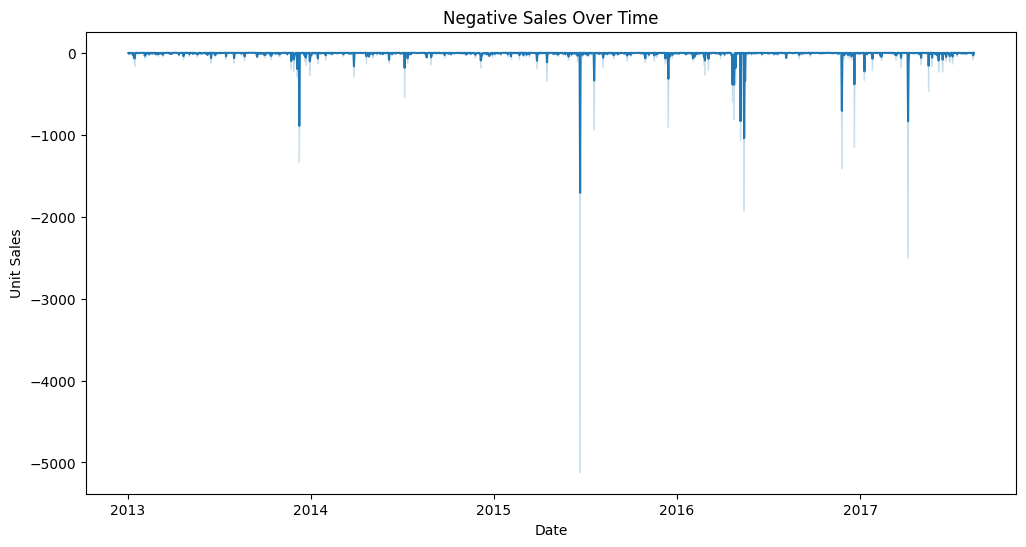

In [94]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)
visualize_negative_sales(df_sales_negative)

c:\Users\alexander\Documents\0. Data Science and AI for Experts\EAISI_4B_Supermarket\venv_case_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


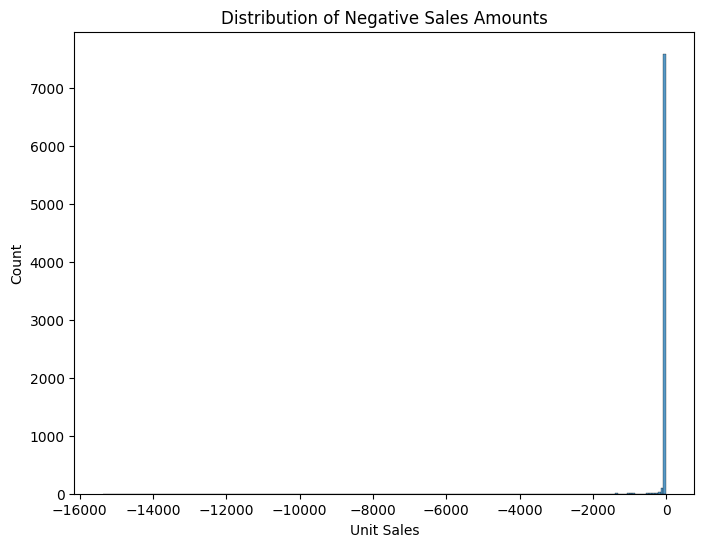

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_sales_negative, x="unit_sales", bins=200)
plt.title("Distribution of Negative Sales Amounts")
plt.xlabel("Unit Sales")
plt.ylabel("Count")
plt.show()

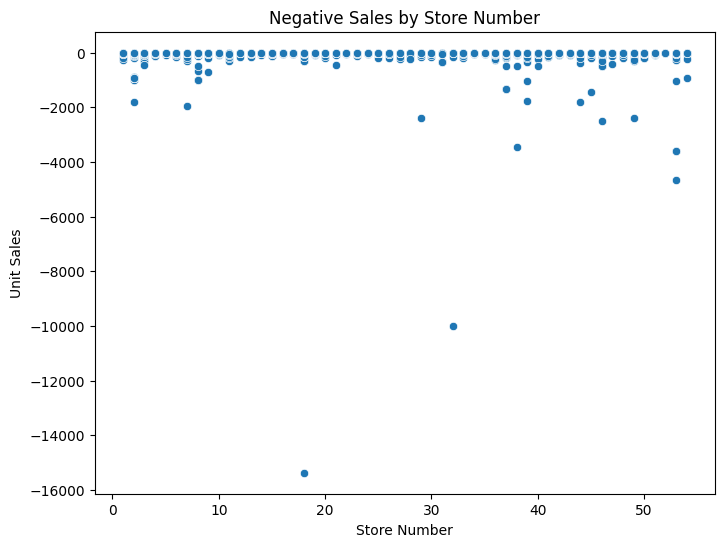

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sales_negative, x="store_nbr", y="unit_sales")
plt.title("Negative Sales by Store Number")
plt.xlabel("Store Number")
plt.ylabel("Unit Sales")
plt.show()

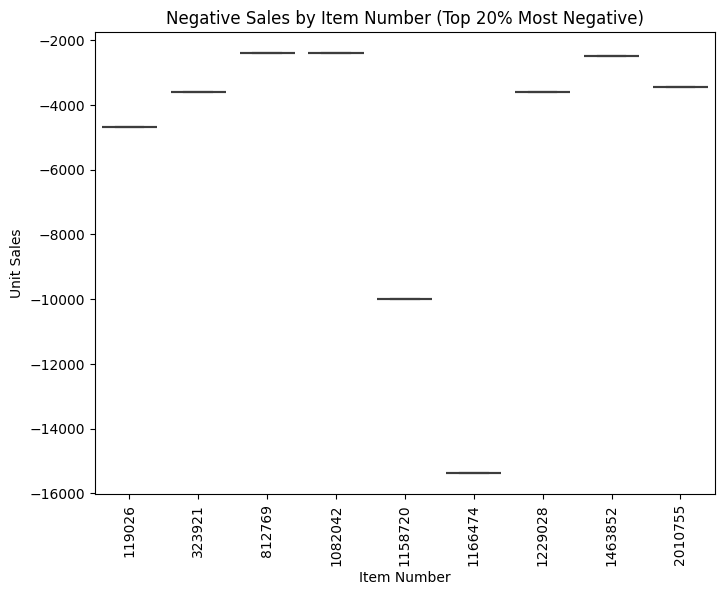

In [104]:
# Calculate the 20th percentile of the negative sales values
negative_sales_threshold = df_sales_negative["unit_sales"].quantile(0.001)

# Filter the 20% most negative sales
df_sales_negative_filtered = df_sales_negative[
    df_sales_negative["unit_sales"] <= negative_sales_threshold
]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_sales_negative_filtered, x="item_nbr", y="unit_sales")
plt.title("Negative Sales by Item Number (Top 20% Most Negative)")
plt.xlabel("Item Number")
plt.ylabel("Unit Sales")
plt.xticks(rotation=90)
plt.show()

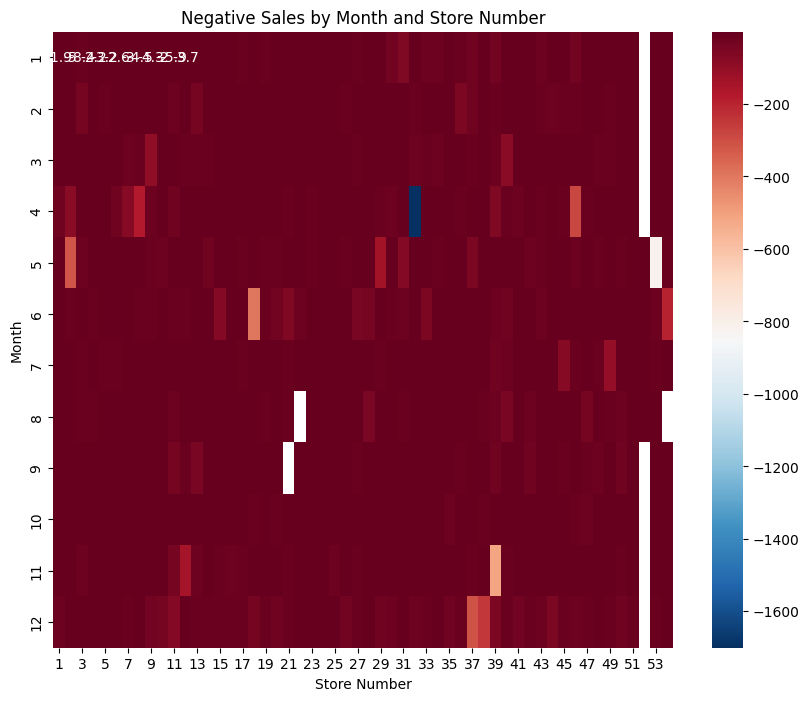

In [98]:
plt.figure(figsize=(10, 8))
pivot_table = df_sales_negative.pivot_table(
    index="month", columns="store_nbr", values="unit_sales"
)
sns.heatmap(pivot_table, annot=True, cmap="RdBu_r")
plt.title("Negative Sales by Month and Store Number")
plt.xlabel("Store Number")
plt.ylabel("Month")
plt.show()

In [15]:
df_sales_negative = df_sales[df_sales["unit_sales"] < 0].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

# --> 7795 records with negative values

-> Contains:                0.0078 million observations and has 6 Feature names: store_nbr, item_nbr, unit_sales, onpromotion, year, and date.

-> Has size of              0.0 GB.


In [43]:
df_sales = f_get_data(0)
df_sales = df_sales.drop(columns=["id", "day", "month"])
df_sales.info()

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    uint8         
 1   item_nbr     uint32        
 2   unit_sales   float32       
 3   onpromotion  boolean       
 4   year         int32         
 5   date         datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(1), uint32(1), uint8(1)
memory usage: 2.7 GB


In [18]:
# Check the number of negative values before replacement
before_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values before replacement: {before_replacement}")

# df_sales = df_sales[df_sales["unit_sales"] < 0]

# Detect and replace negative values with NAs --> .transform() --> should more efficient for larger df's --> takes 20 min to run for full df_sales and then crashes....
df_sales["unit_sales"] = df_sales.groupby(["date", "store_nbr", "item_nbr"])[
    "unit_sales"
].transform(lambda x: x.where(x >= 0, np.nan))

# Check the number of negative values after replacement
after_replacement = (df_sales["unit_sales"] < 0).sum()

print(f"Number of negative values after replacement: {after_replacement}")

Number of negative values before replacement: 7795
Number of negative values after replacement: 0


In [31]:
# Check the number of negative values before replacement
before_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values before replacement: {before_replacement}")

# Create a boolean mask for the negative sales rows to create df containing all negative rows, used to filter full df_sales df
negative_sales_mask = df_sales["unit_sales"] < 0

# Use the mask to update the 'unit_sales' column in the original DataFrame
df_sales.loc[negative_sales_mask, "unit_sales"] = df_sales.loc[
    negative_sales_mask, "unit_sales"
].where(df_sales.loc[negative_sales_mask, "unit_sales"] >= 0, np.nan)

# Check the number of negative values after replacement
after_replacement = (df_sales["unit_sales"] < 0).sum()
print(f"Number of negative values after replacement: {after_replacement}")

Number of negative values before replacement: 7795
Number of negative values after replacement: 0


In [50]:
def negative_sales_cleaned(df):

    # Check the number of negative values before replacement
    before_replacement = (df["unit_sales"] < 0).sum()
    print(f"Number of negative values before replacement: {before_replacement}")

    # Create a boolean mask for the negative sales rows to create a 'boolean flag-list' containing all negative rows, used to filter full df_sales df
    negative_sales_mask = df["unit_sales"] < 0

    # Use the mask to update the flagged 'unit_sales' column in the original DataFrame
    df.loc[negative_sales_mask, "unit_sales"] = df.loc[
        negative_sales_mask, "unit_sales"
    ].where(df.loc[negative_sales_mask, "unit_sales"] >= 0, np.nan)

    # Check the number of negative values after replacement
    after_replacement = (df["unit_sales"] < 0).sum()
    print(f"Number of negative values after replacement: {after_replacement}")

    return df

In [42]:
negative_sales_mask

0            False
1            False
2            False
3            False
4            False
             ...  
125497035    False
125497036    False
125497037    False
125497038    False
125497039    False
Name: unit_sales, Length: 125497040, dtype: bool

In [51]:
df_sales_nan = negative_sales_cleaned(df_sales)

df_sales_nan.info()

Number of negative values before replacement: 7795
Number of negative values after replacement: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   store_nbr    uint8         
 1   item_nbr     uint32        
 2   unit_sales   float32       
 3   onpromotion  boolean       
 4   year         int32         
 5   date         datetime64[ns]
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(1), uint32(1), uint8(1)
memory usage: 2.7 GB


In [37]:
df_sales_nan_check = df_sales_nan[df_sales_nan["unit_sales"].isna()].sort_values(
    by=["date", "store_nbr", "item_nbr"]
)

df_sales_nan_check.head(30)

,store_nbr,item_nbr,unit_sales,onpromotion,year,date
10655,10,456875,NaN,<NA>,2013,2013-01-02
46867,5,559044,NaN,<NA>,2013,2013-01-03
50970,9,365138,NaN,<NA>,2013,2013-01-03
71807,41,812716,NaN,<NA>,2013,2013-01-03
71992,41,1004551,NaN,<NA>,2013,2013-01-03
75255,46,208530,NaN,<NA>,2013,2013-01-03
91163,9,457574,NaN,<NA>,2013,2013-01-04
106658,34,586824,NaN,<NA>,2013,2013-01-04
111811,41,956012,NaN,<NA>,2013,2013-01-04
111813,41,956014,NaN,<NA>,2013,2013-01-04


In [38]:
df_sales_nan.tail(30)

,store_nbr,item_nbr,unit_sales,onpromotion,year,date
124966993,50,1246784,NaN,False,2017,2017-08-10
124989248,7,1226507,NaN,False,2017,2017-08-11
125005757,17,949053,NaN,False,2017,2017-08-11
125008616,18,2056876,NaN,False,2017,2017-08-11
125084806,3,692106,NaN,False,2017,2017-08-12
125087506,4,849941,NaN,False,2017,2017-08-12
125103094,11,1986627,NaN,False,2017,2017-08-12
125119210,21,1464005,NaN,False,2017,2017-08-12
125138939,33,819195,NaN,False,2017,2017-08-12
125152781,41,559872,NaN,False,2017,2017-08-12


In [39]:
df_sales_nan.sample(50)

,store_nbr,item_nbr,unit_sales,onpromotion,year,date
69335241,28,940638,NaN,False,2016,2016-10-01
119715768,4,1464919,NaN,False,2017,2017-06-22
8253856,38,258376,NaN,<NA>,2013,2013-04-03
65246880,47,1171142,NaN,False,2015,2015-09-16
5352479,6,849312,NaN,<NA>,2013,2013-12-26
41576598,10,1913600,NaN,False,2015,2015-10-14
12584891,48,888063,NaN,<NA>,2013,2013-07-10
51173171,30,1179119,NaN,False,2015,2015-03-11
96594488,36,1914280,NaN,False,2016,2016-08-08
7011049,24,890825,NaN,<NA>,2013,2013-03-05


# # Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays 

In [17]:
# Items
df_items = f_get_data(3)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float


In [28]:
print(f"--> df_sales_2013 Contains:")

print(df_sales_2013["item_nbr"].dtype)
print(df_items["item_nbr"].dtype)

# # Change the dtype for item_nbr from uint32 to int32
df_sales_2013["item_nbr"] = df_sales_2013["item_nbr"].astype(int)
df_items["item_nbr"] = df_items["item_nbr"].astype(int)
print("-" * 30)
print(df_sales_2013["item_nbr"].dtype)
print(df_items["item_nbr"].dtype)
print("-" * 30)


df_sales_2013_items = df_sales_2013.merge(df_items, on="item_nbr", how="left")

df_sales_2013_nan = filling_dates_NaN(df_sales_2013_items)

--> df_sales_2013 Contains:
int32
int32
------------------------------
int32
int32
------------------------------


C:\Users\alexander\AppData\Local\Temp\ipykernel_5632\955838949.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_2013["item_nbr"] = df_sales_2013["item_nbr"].astype(int)


First date in df: 2013-01-01 00:00:00
Last date in df:  2013-12-31 00:00:00
-----------------------------------------------------------------------
Start size of df:     0.41 GB and start observations:     16.3 million.
Final size of df:     1.39 GB and end observations:       33.9 million.
Change in size of df: 238.6 % and observations:           107.78     %.
Increased size of df: 0.98 GB and increased observations: 17.6 million.
-----------------------------------------------------------------------


In [14]:
print(f"--> df_sales_2017 Contains:")
df_sales_2017_nan = filling_dates_NaN(df_sales_2017)

--> df_sales_2017 Contains:
First date in df: 2017-01-01 00:00:00
Last date in df:  2017-08-15 00:00:00
-----------------------------------------------------------------------
Start size of df:     0.69 GB and start observations:     23.8 million.
Final size of df:     1.24 GB and end observations:       49.3 million.
Change in size of df: 80.18 % and observations:           106.87     %.
Increased size of df: 0.55 GB and increased observations: 25.4 million.
-----------------------------------------------------------------------


In [31]:
df_sales_2013_nan.head(20)

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,family,class,perishable
0,25,103665,2013-01-01,7.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
1,25,103665,2013-01-02,5.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
2,25,103665,2013-01-03,NaN,<NA>,NaN,NaN,NaN,NaN
3,25,103665,2013-01-04,5.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
4,25,103665,2013-01-05,5.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
5,25,103665,2013-01-06,7.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
6,25,103665,2013-01-07,2.0,<NA>,2013.0,BREAD/BAKERY,2712.0,1.0
7,25,103665,2013-01-08,NaN,<NA>,NaN,NaN,NaN,NaN
8,25,103665,2013-01-09,NaN,<NA>,NaN,NaN,NaN,NaN
9,25,103665,2013-01-10,NaN,<NA>,NaN,NaN,NaN,NaN


In [35]:
# Fill missing values for non-sales columns using forward fill and backward fill --> items, stores, holidays
non_sales_columns = [
    "family",
    "class",
    "perishable",  # be aware of name changes of columns in step 3.X
]
df_sales_2013_nan[non_sales_columns] = df_sales_2013_nan.groupby(
    ["store_nbr", "item_nbr"]
)[non_sales_columns].transform(lambda group: group.ffill().bfill())

In [ ]:
df_sales_2013_nan.head(30)

### >> Downcast and transform data
Update formatting of features to optimize memory and standardize column names.

In [6]:
def standardize_column_names(s):
    return s.replace(" ", "")


def optimize_memory(df):
    # Change: Objects to Categorical.
    object_cols = df.select_dtypes(include="object").columns

    if not object_cols.empty:
        print("Change: Objects to Categorical")
        df[object_cols] = df[object_cols].astype("category")

    # Change: Convert integers to smallest unsigned integer and floats to smallest.
    for old, new in [("integer", "unsigned"), ("float", "float")]:
        print("Change: " + old + " --> " + new)
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)

    return df


def month_year_to_int(df, i):
    # Change: Month and Year to integer.
    if i == 0:
        print("Change: Month and Year to integer")
        df = df.astype({"month": int, "year": int})

    return df

### Transform date-related columns to datetime format.

In [7]:
# Convert datasets to time series
def transform_date_to_datetime(df, i):
    if i == 0:
        print("Change: Transformed 'year', 'month', 'day' columns to Datetime feature")
        df["date"] = pd.to_datetime(df[["year", "month", "day"]], unit="us")

        # print(
        #     "Change: Dropped 'year', 'month', 'day' columns and transformed to Datetime64[us] feature"
        # )
        # df.drop(columns=["day", "month", "year"], inplace=True)

    else:
        if "date" in df.columns:
            print("Change: Transformed 'date' column to Datetime Dtype")
            df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

    return df

### Import data from local PATH
Import data trough pipeline to downcast the data and transformations

In [8]:
def f_get_data(i=0):

    # Define path.
    c_path = "C:/Users/alexander/Documents/0. Data Science and AI for Experts/EAISI_4B_Supermarket/data/raw/"

    # Identify file.
    v_file = (
        "history-per-year",  # 0
        "history_aggregated",  # 1
        "holidays_events",  # 2
        "items",  # 3
        "oil",  # 4
        "stores",  # 5
        "transactions",  # 6
    )

    # Load data.
    df = (
        pd.read_parquet(c_path + v_file[i] + ".parquet")
        .rename(columns=standardize_column_names)
        .pipe(optimize_memory)
        .pipe(month_year_to_int, i)
        .pipe(transform_date_to_datetime, i)
    )

    # Return data.
    return df

### >> Importing data

In [9]:
# Sales History per year
df_0 = f_get_data(0)

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature


In [52]:
# Holidays
df_2 = f_get_data(2)

df_2.head(20)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float
Change: Transformed 'date' column to Datetime Dtype


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [53]:
# Items
df_3 = f_get_data(3)

df_3.head(20)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
5,105574,GROCERY I,1045,0
6,105575,GROCERY I,1045,0
7,105576,GROCERY I,1045,0
8,105577,GROCERY I,1045,0
9,105693,GROCERY I,1034,0


In [55]:
# Stores
df_5 = f_get_data(5)

df_5.head(20)

Change: Objects to Categorical
Change: integer --> unsigned
Change: float --> float


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


### Aggregation of Sales per Month and join of df_0 History sales + df_3 Items + df_5 Stores Datasets

In [ ]:
def onpromotion_month_count(df):

    if "onpromotion" in df.columns:

        df["onpromotion_month_count"] = df.groupby(
            ["item_nbr", "store_nbr", "day", "month", "year"]
        )["onpromotion"].transform("sum")

        print(
            "Change: 'onpromotion' column transformed to 'onpromotion_month_count' feature."
        )
    else:

        print("The DataFrame does not contain an 'onpromotion' column.")

    return df

In [ ]:
df_0_agg = (
    onpromotion_month_count(df_0)  # Transformation to 'onpromotion_month_count' feature
    .drop(
        columns=["id", "date", "onpromotion"]
    )  # Drop unnecessary columns "id", "date", "onpromotion"
    .groupby(["month", "year", "store_nbr", "item_nbr"])
    .agg({"unit_sales": "sum", "onpromotion_month_count": "sum"})
    .reset_index()
)

In [ ]:
df_0_agg.head(20)

In [ ]:
df_0_agg.sample(20)

In [ ]:
# Merge of df_0_agg with df_3 and df_5

df_03_join = df_0_agg.merge(df_3, on="item_nbr", how="left")

df_035_join = df_03_join.merge(df_5, on="store_nbr", how="left")

In [ ]:
print("The transformed and joined data\n")
print(
    f"-> Contains:                {round(df_035_join.shape[0]/1e6, 1)} million observations and {df_035_join.shape[1]} features.\n"
)
print(
    f"-> Contains:                {df_035_join.shape[0]} observations and {df_035_join.shape[1]} features.\n"
)
print(f"-> Have feature names:      {f_concat(df_035_join.columns)}.\n")
print(
    f"-> Has optimized size of    {round(sys.getsizeof(df_035_join)/1024/1024/1024, 2)} GB."
)

In [ ]:
# Sample of final merged dataframe 'df_02_join'

df_035_join.sample(10)

### df_0 History sales join with df_2 Holidays 

In [ ]:
print(
    f"-> Contains:                {round(df_2.shape[0]/1e6, 1)} million observations and {df_2.shape[1]} features.\n"
)
print(
    f"-> Contains:                {df_2.shape[0]} observations and {df_2.shape[1]} features.\n"
)
print(f"-> Have feature names:      {f_concat(df_2.columns)}.\n")
print(f"-> Has optimized size of    {round(sys.getsizeof(df_2)/1024/1024/1024, 2)} GB.")

df_2.sample(10)

In [ ]:
get_unique(df_2, "locale_name")

In [ ]:
# drop unnecessary columns 'description'
df_2_cleaned = df_2.drop(columns=["description"])

df_2_cleaned.sample(10)

In [ ]:
# Added feature to indicate whether a date is a holiday

df_2_cleaned["is_holiday"] = df_2_cleaned["type"] == "Holiday"
df_2_cleaned.loc[df_2_cleaned["transferred"], "is_holiday"] = (
    False  # Handle transferred holidays
)

In [ ]:
# drop unnecessary columns 'id' to save memory
df_0_cleaned = df_0.drop(
    columns=[
        "id",
        "day",
        "year",
        "month",
        "onpromotion",
        # , "onpromotion_month_count"
    ]
)

In [ ]:
# Merge of df_0_cleaned with df_2

df_02_join = df_0_cleaned.merge(df_2_cleaned, on="date", '',how="left")

In [ ]:
print(
    f"-> Contains:                {round(df_02_join.shape[0]/1e6, 1)} million observations and {df_02_join.shape[1]} features.\n"
)
print(
    f"-> Contains:                {df_02_join.shape[0]} observations and {df_02_join.shape[1]} features.\n"
)
print(f"-> Have feature names:      {f_concat(df_02_join.columns)}.\n")
print(
    f"-> Has optimized size of    {round(sys.getsizeof(df_02_join)/1024/1024/1024, 2)} GB."
)

In [ ]:
# Sample of final merged dataframe 'df_02_join'

df_02_join.sample(10)

In [ ]:
df_02_join.sample(10)

In [ ]:
df_02_join = pd.get_dummies(
    df_02_join, columns=["type"], dummy_na=False, prefix="holidayType"
)
df_02_join = pd.get_dummies(
    df_02_join, columns=["locale"], dummy_na=False, prefix="holidayLocale"
)
df_02_join = pd.get_dummies(
    df_02_join, columns=["transferred"], dummy_na=False, prefix="holidayTransferred"
)

In [ ]:
df_02_cleaned = df_02_join.drop(["transferred"])

In [ ]:
# Set the row limit to a higher value
alt.data_transformers.disable_max_rows()

scatter_plot = (
    alt.Chart(df_02_join)
    .mark_point(filled=True, size=60)
    .encode(
        x=alt.X("date:T", title="Date"),
        y=alt.Y("sales:Q", title="Sales"),
        color=alt.condition(
            alt.datum.condition,
            alt.value("blue"),  # Non-holidays sales
            alt.value("red"),  # Holidays sales
        ),
        tooltip=["date", "sales", "condition"],
    )
    .properties(title="Sales by the Date", width=1200, height=600)
    .interactive()
)

scatter_plot.display()

In [ ]:
get_unique(df_02_join, "type")

## >>  Merge holidays with stores

In [ ]:
# Clean df_2 and df_5 by dropping unneeded columns to same memory and prepare for prossessing

df_2_cleaned = df_2.drop(
    columns=[
        "description"
        # , "transferred"
    ]
)

df_5_cleaned = df_5.drop(columns=["cluster", "type"])

In [ ]:
# select locale 'Local' from holiday df and merge with city stores df
df_2_local = df_2_cleaned[df_2_cleaned["locale"] == "Local"]


df_25_local = df_2_local.merge(
    df_5_cleaned, left_on="locale_name", right_on="city", how="left"
)

In [ ]:
# df_25_local_45 = df_25_local[df_25_local["store_nbr"] == 43]

# df_25_local_45.sample()

In [ ]:
# select locale 'Regional' from holiday df and merge with state stores df
df_2_regional = df_2_cleaned[df_2_cleaned["locale"] == "Regional"]


df_25_regional = df_2_regional.merge(
    df_5_cleaned, left_on="locale_name", right_on="state", how="left"
)

In [ ]:
# select locale 'National' from holiday df and merge with national stores df
df_2_national = df_2_cleaned[df_2_cleaned["locale"] == "National"]

# create extra column for merge on "Ecuador"
df_5_cleaned["national_merge"] = "Ecuador"


df_25_national = df_2_national.merge(
    df_5_cleaned,
    left_on="locale_name",
    right_on="national_merge",
    how="left",
)


df_25_national = df_25_national.drop(columns=["national_merge"])

# Combine local, regional and national dataframes into 1 merged dataframe

df_25_union = pd.concat([df_25_local, df_25_regional, df_25_national])

# clean df by dropping locale_name", "city", "state to save memory

df_25_union_cleaned = df_25_union.drop(columns=["locale_name", "city", "state"])

In [ ]:
get_unique(df_2_national, "locale_name")

In [ ]:
print(
    f"-> Local Contains:                {df_25_local.shape[0]} observations and {df_25_local.shape[1]} features.\n"
)
print(
    f"-> Regional Contains:             {df_25_regional.shape[0]} observations and {df_25_regional.shape[1]} features.\n"
)
print(
    f"-> National Contains:             {df_25_national.shape[0]} observations and {df_25_national.shape[1]} features.\n"
)

In [ ]:
# Combine local, regional and national dataframes into 1 merged dataframe

df_25_union = pd.concat([df_25_local, df_25_regional, df_25_national])

In [ ]:
# Check and compare individual df's with union dataframe
total_observations = (
    df_25_local.shape[0] + df_25_regional.shape[0] + df_25_national.shape[0]
)


print(f"-> Union should Contain:            {total_observations} observations\n")


print(
    f"-> Union Contains:                  {df_25_union.shape[0]} observations and {df_25_union.shape[1]} features.\n"
)

In [ ]:
# df_25_union.sample(20)
# get_unique(df_25_union, "locale_name")

In [ ]:
# clean df by dropping locale_name", "city", "state to save memory

df_25_union_cleaned = df_25_union.drop(columns=["locale_name", "city", "state"])

In [ ]:
# prepare seperate df to add store type back to full df

df_5_store_type = df_5.rename(columns={"type": "store_type"}).drop(
    columns=["city", "state", "cluster"]
)

In [ ]:
def fill_normal_holidays(df):
    cat_col = df.select_dtypes(include=["category"]).columns

    for col in cat_col:
        if "No" not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories("No")

    df = df.fillna("No")

    return df

In [ ]:
def merge_df_02(df):

    df = df.drop(columns=columns_to_drop)

    df = df.merge(df_25_union_cleaned, on=["date", "store_nbr"], how="left")

    df = df.merge(df_5_store_type, on=["store_nbr"], how="left")

    df = fill_normal_holidays(df)

    return df


# drop unnecessary columns to save memory in df's

columns_to_drop = [
    "id",
    "day",
    # "year",
    "month",
    "onpromotion",
]

In [ ]:
df_02_full = merge_df_02(df_0)

df_02_full.info()

In [ ]:
df_02_full.sample(10)

## Try-out code

In [ ]:
df_0_2012 = df_0[(df_0["year"] == 2012)]

df_0_2012

In [ ]:
def df_year_split_cleaned(df, year):

    df = df[(df["year"] == year)]

    df = df.drop(columns=columns_to_drop)

    return df


# drop unnecessary columns to save memory in df's

columns_to_drop = [
    "id",
    "day",
    "year",
    "month",
    "onpromotion",
]

In [ ]:
df_year_split_cleaned(df_0, 2013)

In [ ]:
# df_0_2013 = df_0[(df_0["year"] == 2013)]
# df_0_2014 = df_0[(df_0["year"] == 2014)]
# df_0_2015 = df_0[(df_0["year"] == 2015)]
# df_0_2016 = df_0[(df_0["year"] == 2016)]
# df_0_2017 = df_0[(df_0["year"] == 2017)]

In [ ]:
# # drop unnecessary columns to save memory in df's

# columns_to_drop = [
#     "id",
#     "day",
#     "year",
#     "month",
#     "onpromotion",
# ]


# def clean_df_0(df):

#     df_cleaned = df.drop(columns=columns_to_drop)

#     return df_cleaned

In [ ]:
# df_0_cleaned_2012 = clean_df_0(df_0_2012)
# df_0_cleaned_2013 = clean_df_0(df_0_2013)
# df_0_cleaned_2014 = clean_df_0(df_0_2014)
# df_0_cleaned_2015 = clean_df_0(df_0_2015)
# df_0_cleaned_2016 = clean_df_0(df_0_2016)
# df_0_cleaned_2017 = clean_df_0(df_0_2017)

In [ ]:
df_0_cleaned_2013 = df_year_split_cleaned(df_0, 2013)

In [ ]:
df_0_cleaned_2013.head(10)

In [ ]:
df_25_union_cleaned.head(10)

In [ ]:
def merge_df_02(df):

    df = df.drop(columns=columns_to_drop)

    df = df.merge(df_25_union_cleaned, on=["date", "store_nbr"], how="left")

    df = fill_normal_holidays(df)

    return df


# drop unnecessary columns to save memory in df's

columns_to_drop = [
    "id",
    "day",
    # "year",
    "month",
    "onpromotion",
]

df_02_full = merge_df_02(df_0)

df_02_full.info()

In [ ]:
df_02_join_2013 = fill_normal_holidays(df_02_join_2013)

df_02_join_2013.tail(10)

In [ ]:
df_02_join_2013.info()

In [ ]:
df_02_join_2013.sample(10)

In [ ]:
get_unique(df_02_join_2013, "type")

In [ ]:
get_unique(df_02_join_2013, "locale")

## Plots

In [ ]:
# Timeseries of Sales by Locale

aggregated_data = (
    df_02_join_2013.groupby(["date", "locale"])["unit_sales"].sum().reset_index()
)

# Timeseries of Sales by Locale
chart = (
    alt.Chart(aggregated_data)
    .mark_bar()
    .encode(
        x="date:T",
        y="unit_sales:Q",
        color="locale:N",
        tooltip=["date", "unit_sales", "locale"],
    )
    .properties(
        title="Holiday's - Timeseries of Sales by Locale", width=800, height=400
    )
    .interactive()
)

# Display the chart
chart.display()

In [ ]:
# Timeseries of Sales by type

aggregated_data = (
    df_02_join_2013.groupby(["date", "type"])["unit_sales"].sum().reset_index()
)

# Timeseries of Sales by Locale
chart = (
    alt.Chart(aggregated_data)
    .mark_bar()
    .encode(
        x="date:T",
        y="unit_sales:Q",
        color="type:N",
        tooltip=["date", "unit_sales", "type"],
    )
    .properties(
        title="Holiday's - Timeseries of Sales by Holiday", width=800, height=400
    )
    .interactive()
)

chart.display()

In [ ]:
# Timeseries of Sales by Type and store_nbr

aggregated_data = (
    df_02_join_2013.groupby(["date", "store_nbr", "type"])["unit_sales"]
    .sum()
    .reset_index()
)

# Timeseries of Sales by Locale
chart = (
    alt.Chart(aggregated_data)
    .mark_circle()
    .encode(
        x="date:T",
        y="unit_sales:Q",
        color="type:N",
        tooltip=["date", "unit_sales", "type", "store_nbr"],
    )
    .properties(
        title="Holiday's - Timeseries of Sales by type and store_nbr ",
        width=800,
        height=400,
    )
    .interactive()
)

chart.display()

In [ ]:
## Timeseries of Sales by locale and store_nbr

aggregated_data = (
    df_02_join_2013.groupby(["date", "store_nbr", "locale"])["unit_sales"]
    .sum()
    .reset_index()
)

chart = (
    alt.Chart(aggregated_data)
    .mark_bar()
    .encode(
        x="date:T",
        y="unit_sales:Q",
        color=alt.Color(
            "store_nbr:N",
        ),
        tooltip=["date", "unit_sales", "locale", "store_nbr"],
    )
    .properties(
        title="Holiday's - Timeseries of Sales by locale and store_nbr",
        width=800,
        height=400,
    )
    .interactive()
)

chart.display()

# To-do: brainstorm on how to show effect of holidays on indv stores

In [ ]:
# Timeseries of Sales by type

aggregated_data = (
    df_02_join_2013.groupby(["date"])
    .agg({"type": "first", "date": "first", "unit_sales": "sum"})
    .reset_index(drop=True)
)

# Base chart
base_aggregated_data = (
    df_02_join_2013.groupby(["date"])["unit_sales"].sum().reset_index()
)

line_chart = (
    alt.Chart(base_aggregated_data)
    .mark_line()
    .encode(
        x="date:T",
        y="unit_sales:Q",
    )
    .properties(width=800, height=400)
)

# Overlay points for types
legend_data = aggregated_data[aggregated_data["type"] != "No"]

point_chart = (
    alt.Chart(legend_data)
    .mark_point()
    .encode(
        x="date:T",
        y="unit_sales:Q",
        shape=alt.Shape("type:N", legend=alt.Legend(title="Type")),
        color="type:N",
        tooltip=["date", "unit_sales", "type"],
    )
)

# Combine charts
combined_chart = line_chart + point_chart

combined_chart = combined_chart.properties(
    title="Timeseries of Total Sales by Type",
).interactive()

combined_chart.display()

In [ ]:
df_02_join_2013.sample(20)


def holiday_sales_stores_1item(df, item_nbr):

    df = df[(df["item_nbr"] == item_nbr)]

    return df

In [ ]:
df_502331_2013 = holiday_sales_stores_1item(df_02_join_2013, 502331)

df_502331_2013.head(10)

##Note: item 502331 has sales on 01-01-2013 for store 25 with holiday remark, rest stores start sales on 02-01-2013

In [ ]:
df_617763_2013 = holiday_sales_stores_1item(df_02_join_2013, 617763)

df_617763_2013.head(10)

df_617763_2013.sample(10)
##Note: item 617763 has no sales on 01-01-2013 for none of the stores, all stores start sales on 02-01-2013.

In [ ]:
def holiday_chart_item(df, item_nbr):

    df = df[(df["item_nbr"] == item_nbr)]

    line_chart = (
        alt.Chart(df)
        .mark_line()
        .encode(
            x="date:T",
            y="unit_sales:Q",
        )
        .properties(width=800, height=400)
    )

    # Overlay points for type or locale
    legend_data = df[df["locale"] != "No"]

    point_chart = (
        alt.Chart(legend_data)
        .mark_point()
        .encode(
            x="date:T",
            y="unit_sales:Q",
            shape=alt.Shape("locale:N", legend=alt.Legend(title="Locale")),
            color="locale:N",
            tooltip=["date", "unit_sales", "locale"],
        )
    )

    # Combine charts
    combined_chart = line_chart + point_chart

    combined_chart = combined_chart.properties(
        title="Timeseries of unit Sales for item {item_nbr}",
    ).interactive()

    combined_chart.display()

In [ ]:
holiday_chart_item(df_02_join_2013, 617763)

In [ ]:
def holiday_chart_item(df, item_nbr):

    # Filter the DataFrame for the specific item number
    df = df[df["item_nbr"] == item_nbr]

    # Define the base chart with the data at the top level
    base = (
        alt.Chart(df)
        .encode(x="date:T", y="unit_sales:Q"),
        .properties(
            width=300,
            height=200
            )
    )

    # Create the line chart
    line_chart = base.mark_line().encode(color="store_nbr:N")

    # Overlay points for type or locale
    point_chart = (
        base.mark_point()
        .encode(
            shape=alt.Shape("locale:N", legend=alt.Legend(title="Locale")),
            color="locale:N",
            tooltip=["date", "unit_sales", "locale", "store_nbr"],
        )
        .transform_filter(
            (
                alt.datum.locale != "No"
            )  # filter out rows where locale is 'No' for the point chart
        )
    )

    # Combine line and point charts
    combined_chart = alt.layer(line_chart, point_chart)

    # Facet by store number
    facet_chart = (
        combined_chart.facet(
            facet="store_nbr:N", columns=3  # Number of columns in the facet grid
        )
        .properties(title=f"Timeseries of Unit Sales for Item {item_nbr} per store")
        .interactive()
    )

    # Display the chart
    facet_chart.display()

In [ ]:
holiday_chart_item(df_02_join_2013, 617763)

In [ ]:
holiday_chart_item(df_02_join_2013, 502331)

In [ ]:
# def merge_df_02(df):

#     df = df.drop(columns=columns_to_drop)

#     df = df.merge(df_25_union_cleaned, on=["date", "store_nbr"], how="left")

#     df = fill_normal_holidays(df)

#     return df


# # drop unnecessary columns to save memory in df's

# columns_to_drop = [
#     "id",
#     "day",
#     # "year",
#     "month",
#     "onpromotion",
# ]

In [ ]:
df_02_full = merge_df_02(df_0)


df_02_full.info()

In [ ]:
+df_02_full.sample(10)

In [ ]:
def holiday_chart_item_years(df, item_nbr):

    # Filter the DataFrame for the specific item number
    df = df[df["item_nbr"] == item_nbr]

    # Define the base chart with the data at the top level
    base = (
        alt.Chart(df)
        .encode(
            x="date:T",
            y="unit_sales:Q",
            color="year:N",
        )
        .properties(width=300, height=200)
    )

    # Create the line chart
    # line_chart = base.mark_line()

    line_chart = base.mark_line().encode(
        color=alt.Color("year:N", legend=alt.Legend(title="Year"))
    )

    # Overlay points for type or locale
    point_chart = (
        base.mark_point()
        .encode(
            shape=alt.Shape("locale:N", legend=alt.Legend(title="Locale")),
            color="locale:N",
            tooltip=["date", "unit_sales", "locale", "store_nbr", "year"],
        )
        .transform_filter(
            (
                alt.datum.locale != "No"
            )  # filter out rows where locale is 'No' for the point chart
        )
    )

    # Combine line and point charts
    combined_chart = alt.layer(line_chart, point_chart)

    # Facet by store number
    facet_chart = (
        combined_chart.facet(
            facet="store_nbr:N",
            columns=3,
            title=f"Timeseries of Unit Sales for Item {item_nbr} per Store per Year",
        )
        .resolve_scale(y="independent")
        .interactive()
    )

    # Display the chart
    facet_chart.display()

In [ ]:
get_unique(df_02_full, "item_nbr")

In [ ]:
# Plot Timeseries of Unit Sales for Item 502331 per Store per Year
holiday_chart_item_years(df_02_full, 119024)

##note: lot of spikes!

In [ ]:
holiday_chart_item_years(df_02_full, 119024)

In [ ]:
get_unique(df_02_full, "type")

In [ ]:
df_02_full["month"] = df_02_full["date"].dt.month
df_02_full["month"] = pd.to_datetime(df_02_full["date"]).dt.month

df_02_full["type"] = df_02_full["type"].replace("No", np.nan)

# data
df_y_m_ht = (
    df_02_full.groupby(["year", "month", "type"])
    .agg({"unit_sales": "mean"})
    .reset_index()
)
df_y_m_ht["unit_sales"] = round(df_y_m_ht["unit_sales"], 2)

# month mapping
month_mapping = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}
df_y_m_ht["month"] = df_y_m_ht["month"].map(month_mapping)

# base chart
base = (
    alt.Chart(df_y_m_ht)
    .mark_point(filled=True)
    .encode(
        x=alt.X(
            "month:O",
            title="",
            sort=list(month_mapping.values()),
            axis=alt.Axis(labelAngle=0),
        ),
        y=alt.Y("type:N", title=""),
        color=alt.Color("unit_sales:Q", scale=alt.Scale(scheme="inferno")),
        size=alt.Size("unit_sales:Q"),
        tooltip=["year", "month", "type", "unit_sales"],
    )
    .properties(
        width=600,
        height=200,
    )
)


# facet chart
chart = base.facet(row="year:N").properties(
    title=alt.TitleParams(
        "Average Sales: Holiday_type Vs Year (Month)",
    ),
)

chart.show()

In [ ]:
df_02_full["month"] = df_02_full["date"].dt.month
df_02_full["month"] = pd.to_datetime(df_02_full["date"]).dt.month

df_02_full["type"] = df_02_full["type"].replace("No", np.nan)


# Data aggregation
df_y_m_st = (
    df_02_full.groupby(["year", "month", "store_type"])
    .agg({"unit_sales": "sum"})
    .reset_index()
)

df_y_m_st["unit_sales"] = round(df_y_m_st["unit_sales"], 2)

# Month mapping
month_mapping = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}
df_y_m_st["month"] = df_y_m_st["month"].map(month_mapping)

# Base chart
base = (
    alt.Chart(df_y_m_st)
    .mark_point(filled=True)
    .encode(
        x=alt.X(
            "month:O",
            title="Month",
            sort=list(month_mapping.values()),
            axis=alt.Axis(labelAngle=0, grid=True),
        ),
        y=alt.Y("store_type:N", title="Store Type", axis=alt.Axis(grid=True)),
        color=alt.Color("unit_sales:Q", scale=alt.Scale(scheme="inferno")),
        size=alt.Size("unit_sales:Q"),
        tooltip=["year", "month", "store_type", "unit_sales"],
    )
    .properties(
        width=600,
        height=200,
    )
)

# Facet chart
chart = base.facet(row="year:N").properties(
    title=alt.TitleParams(
        "Average Sales: Store Type vs Month  ",
    )
)

# Display chart
chart.show()

In [ ]:
df_02_full[df_02_full["store_nbr"] == 45].sample(5)

In [ ]:
# df_test = df_02_full[df_02_full["store_nbr"] == 45]

# # aggregated_df = (
# #         df_test.groupby(["date", "type"]).agg({"unit_sales": "sum"}).reset_index()
# #     )

# aggregated_df = (
#     df_test.groupby(["date"])
#     .agg({"type": "first", "date": "first", "unit_sales": "sum"})
#     .reset_index(drop=True)
# )

# aggregated_df.tail(10)

In [ ]:
df = df_02_full
store_nbr = 45
x_days = 5

# Select data from specific store
df = df[df["store_nbr"] == store_nbr]

# Aggegrate unit_sales summed up per day
aggregated_df = (
    df.groupby(["date"])
    .agg({"type": "first", "date": "first", "unit_sales": "sum"})
    .reset_index(drop=True)
)

# Filter the data to exclude 'No' in the 'type' column and select the 'date' column
holiday_dates = aggregated_df[aggregated_df["type"] != "No"]["date"]

# Initialize an empty DataFrame to collect the results
result_df = pd.DataFrame()

# Iterate through each holiday date and extract the required range
for holiday_date in holiday_dates:
    date_range = pd.date_range(
        start=holiday_date - pd.Timedelta(days=x_days),
        end=holiday_date + pd.Timedelta(days=x_days),
    )

    temp_df = aggregated_df.loc[
        aggregated_df.index.intersection(date_range)
    ].reset_index()
    temp_df["holiday_date"] = holiday_date
    temp_df["days_from_holiday"] = (temp_df["date"] - holiday_date).dt.days
    result_df = pd.concat([result_df, temp_df])

    # Reset the index for the combined DataFrame
    result_df.reset_index(drop=True, inplace=True)

    # Create the Altair plot
    chart = (
        alt.Chart(result_df)
        .mark_line(point=True)
        .encode(
            x=alt.X("days_from_holiday:Q", title=f"{x_days} Days from Holiday"),
            y=alt.Y("unit_sales:Q", title="Unit Sales"),
            color=alt.Color("type:N", title="Holiday Type"),
            tooltip=[
                "unit_sales",
                "date",
                "type",
                "store_type",
                "holiday_date",
                "days_from_holiday",
            ],
        )
        .properties(
            width=800,
            height=400,
            title=f"Sales for {x_days} Days Before and After Holiday for Store {store_nbr}",
        )
    )

    chart.show()

In [ ]:
df = df_02_full
store_nbr = 45
x_days = 5

# Select data from specific store
df = df[df["store_nbr"] == store_nbr]

# Aggegrate unit_sales summed up per day
aggregated_df = (
    df.groupby(["date"])
    .agg({"type": "first", "date": "first", "unit_sales": "sum"})
    .reset_index(drop=True)
)

# Set date column as Index
aggregated_df.set_index("date", inplace=True)

# Filter the data to exclude 'No' in the 'type' column and select the 'date' column
holiday_dates = aggregated_df[aggregated_df["type"] != "No"]["date"]

holiday_dates.head(20)

# Initialize an empty DataFrame to collect the results
result_df = pd.DataFrame()

# Iterate through each holiday date and extract the required range
for holiday_date in holiday_dates:
    date_range = pd.date_range(
        start=holiday_date - pd.Timedelta(days=x_days),
        end=holiday_date + pd.Timedelta(days=x_days),
    )

    print(date_range)  # --> geeft list met juiste dates

    print(aggregated_df.head(10))  # --> aggregated_df bevat juiste data

    # Use boolean indexing to filter the date range
    temp_df = aggregated_df.loc[date_range].reset_index()

    temp_df["holiday_date"] = holiday_date

    print(holiday_date)  # --> Shows the correct holiday date

    print(temp_df.head(10))  # --> temp_df should no longer be empty

    temp_df["days_from_holiday"] = (temp_df["date"] - holiday_date).dt.days

    print(temp_df["days_from_holiday"])

    result_df = pd.concat([result_df, temp_df])

    print(temp_df.head(10))

    # Reset the index for the combined DataFrame
    # result_df.reset_index(drop=True, inplace=True)

result_df.head(20)

In [ ]:
# Assuming df_02_full is already defined
df = df_02_full
store_nbr = 45
x_days = 5

# Select data from specific store
df = df[df["store_nbr"] == store_nbr]

# Aggregate unit_sales summed up per day
aggregated_df = (
    df.groupby("date").agg({"type": "first", "unit_sales": "sum"}).reset_index()
)

# Set date column as Index
aggregated_df.set_index("date", inplace=True)

# Filter the data to exclude 'No' in the 'type' column and select the 'date' column
holiday_dates = aggregated_df[aggregated_df["type"] != "No"].index

# Initialize an empty DataFrame to collect the results
result_df = pd.DataFrame()

# Iterate through each holiday date and extract the required range
for holiday_date in holiday_dates:
    # Create a date range with a buffer of x_days around the holiday_date
    date_range = pd.date_range(
        start=holiday_date - pd.Timedelta(days=x_days),
        end=holiday_date + pd.Timedelta(days=x_days),
    )

    # Filter aggregated_df for dates within the date_range
    # temp_df = aggregated_df.loc[date_range].reset_index()

    temp_df = aggregated_df.loc[
        aggregated_df.index.intersection(date_range)
    ].reset_index()

    # Ensure the 'date' column is accessible and not renamed to 'index'
    temp_df.rename(columns={"index": "date"}, inplace=True)

    # Filter aggregated_df for dates within the date_range
    #

    # print(temp_df.head(10))

    # Ensure the 'date' column is accessible
    if "index" not in temp_df.columns:
        raise KeyError("'date' column not found in temp_df after reset_index()")

    temp_df["holiday_date"] = holiday_date
    temp_df["days_from_holiday"] = (temp_df["date"] - holiday_date).dt.days

    # Append temp_df to result_df
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

    print(result_df.info())

    print("-" * 60)

    print(result_df.head(10))

    # Create the Altair plot
    chart = (
        alt.Chart(result_df)
        .mark_line(point=True)
        .encode(
            x=alt.X("days_from_holiday:Q", title=f"Date as {x_days} Days from Holiday"),
            y=alt.Y("unit_sales:Q", title="Unit Sales"),
            color=alt.Color("type:N", title="Holiday Type"),
            tooltip=[
                "unit_sales",
                "date",
                "type",
                # "store_type",
                "holiday_date",
                "days_from_holiday",
            ],
        )
        .properties(
            width=800,
            height=400,
            title=f"Sales for {x_days} Days Before and After Holiday for Store {store_nbr}",
        )
    )

    chart.show()

    print("-+" * 30)

# Reset the index for the combined DataFrame
result_df.reset_index(drop=True, inplace=True)

In [ ]:
df = df_02_full
store_nbr = 45
x_days = 5

# Select data from specific store
df = df[df["store_nbr"] == store_nbr]

# Aggegrate unit_sales summed up per day
aggregated_df = (
    df.groupby(["date"])
    .agg({"type": "first", "date": "first", "unit_sales": "sum"})
    .reset_index(drop=True)
)

# Filter the data to exclude 'No' in the 'type' column and select the 'date' column
# holiday_dates = aggregated_df[aggregated_df["type"] != "No"]["date"]

# holiday_dates.describe()
# --> for store 45 there are 146 holiday sales-dates


aggregated_df = aggregated_df[aggregated_df["type"] != "No"]

aggregated_df.head(10)

In [ ]:
# Aggregate data and set index
aggregated_df = df.groupby(["date", "type"]).agg({"unit_sales": "sum"}).reset_index()

# Filter the data to exclude 'No' in the 'type' column and select the 'date' column
test2 = aggregated_df[aggregated_df["type"] != "No"]["date"]

# Display the first 10 entries
test2.head(10)

In [ ]:
def Xdays_holiday_sales(df, store_nbr, x_days):

    # Select data from specific store
    df = df[df["store_nbr"] == store_nbr]

    # Aggegrate unit_sales summed up per day
    aggregated_df = (
        df.groupby(["date"])
        .agg({"type": "first", "date": "first", "unit_sales": "sum"})
        .reset_index(drop=True)
    )

    # Set date as index for easier date range operations
    aggregated_df.set_index("date", inplace=True)

    # Extract the relevant dates for holidays
    holiday_dates = aggregated_df[aggregated_df["type"].notna()]["date"]

    # Initialize an empty DataFrame to collect the results
    result_df = pd.DataFrame()

    # Iterate through each holiday date and extract the required range
    for holiday_date in holiday_dates:
        date_range = pd.date_range(
            start=holiday_date - pd.Timedelta(days=x_days),
            end=holiday_date + pd.Timedelta(days=x_days),
        )

        temp_df = aggregated_df.loc[
            aggregated_df.index.intersection(date_range)
        ].reset_index()
        temp_df["holiday_date"] = holiday_date
        temp_df["days_from_holiday"] = (temp_df["date"] - holiday_date).dt.days
        result_df = pd.concat([result_df, temp_df])

    # Reset the index for the combined DataFrame
    result_df.reset_index(drop=True, inplace=True)

    # Create the Altair plot
    chart = (
        alt.Chart(result_df)
        .mark_line(point=True)
        .encode(
            x=alt.X("days_from_holiday:Q", title=f"{x_days} Days from Holiday"),
            y=alt.Y("unit_sales:Q", title="Unit Sales"),
            color=alt.Color("type:N", title="Holiday Type"),
            tooltip=[
                "unit_sales",
                "date",
                "type",
                "locale",
                "store_type",
                "holiday_date",
                "days_from_holiday",
            ],
        )
        .properties(
            width=800,
            height=400,
            title=f"Sales for {x_days} Days Before and After Holiday for Store {store_nbr}",
        )
    )

    chart.show()

    return chart

In [ ]:
Xdays_holiday_sales(df_02_full, store_nbr=45, x_days=5)